In [1]:
import sys
sys.path.append('/home/waleed/fastjet-install/lib/python3.6/site-packages')

In [2]:
import h5py
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import fastjet as fj
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

In [3]:
# Load files
fn_qcd  = '/home/waleed/Desktop/LHC-Olympics/events_LHCO2020_backgroundMC_Pythia.h5'
fn_sig  = '/home/waleed/Desktop/LHC-Olympics/events_anomalydetection.h5'
fn_data = '/home/waleed/Desktop/LHC-Olympics/events_LHCO2020_BlackBox1.h5' 

In [4]:
def read_file(path='', nevts=1e4):
    f = pd.read_hdf(path,stop=nevts)
    
    # change naming convention of the coulmns
    #old = list(f.columns)
    #new = ['pt','eta','phi']
    #new = [new]*700
    #new = [item for sublist in new for item in sublist]
    #dictionary = dict(zip(old, new))
    #df = f.rename(dictionary, axis=1)
    
    return f

def run(data,n_events=1000):
    
    out = []
    
    # Loop over events
    for ievt in range(n_events):

        # Build a list of all particles
        pjs = []
        for i in range(data.shape[1]):
            pj = fj.PseudoJet()
            pj.reset_PtYPhiM(data[ievt,i,0],data[ievt,i,1],data[ievt,i,2],0)
            pjs.append(pj)

        # run jet clustering with AntiKt, R=1.0
        R = 1.0
        jet_def = fj.JetDefinition(fj.antikt_algorithm, R)

        # Save the two leading jets
        jets = jet_def(pjs)
        jets = [j for j in jets if j.pt()>30.]
        out.append([jets[0],jets[1]])
                
    return out

def select_sgn(df=None):
    X, y = df.iloc[:,0:-1], df.iloc[:,-1]
    X['labels']=y
    X = X.loc[X.labels>0.0]
    return X

def preprocess(df=None):
    df = np.array(df)
    hadrons = []
    for item in tqdm(df):
        l = np.array(np.split(item, 700))
        hadrons.append(l)
    
    hadrons = np.array(hadrons)
    return hadrons

In [5]:
qcd  = read_file(fn_qcd)
data = read_file(fn_data)

In [6]:
wpr  = read_file(fn_sig,0.5e5)

In [7]:
print (qcd.shape, wpr.shape, data.shape)

(10000, 2100) (50000, 2101) (10000, 2100)


In [8]:
wpr = select_sgn(wpr)

In [9]:
wpr = wpr.iloc[:,0:-1]

In [10]:
qcd = preprocess(qcd)

100%|██████████| 10000/10000 [00:10<00:00, 936.68it/s]


In [11]:
wpr = preprocess(wpr)

100%|██████████| 4450/4450 [00:04<00:00, 940.95it/s]


In [12]:
data = preprocess(data)

100%|██████████| 10000/10000 [00:10<00:00, 968.76it/s]


In [13]:
# Actually run
# (this may take a few minutes)
out_qcd = run(qcd)

In [14]:
out_sig = run(wpr)

In [15]:
out_data = run(data)

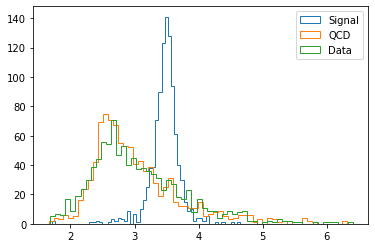

In [16]:
# Extract the leading dijet mass for signal..
dijet_m_sig = []
for evt in out_sig:
    dijet_m_sig.append( (evt[0]+evt[1]).m())

# ..and background
dijet_m_qcd = []
for evt in out_qcd:
    dijet_m_qcd.append( (evt[0]+evt[1]).m())
    
# ..and data
dijet_m_data = []
for evt in out_data:
    dijet_m_data.append( (evt[0]+evt[1]).m())    

# and plot
_ = plt.hist(np.array(dijet_m_sig)*1e-3,label='Signal',bins=60,histtype='step')
_ = plt.hist(np.array(dijet_m_qcd)*1e-3,label='QCD',bins=60,histtype='step')
_ = plt.hist(np.array(dijet_m_data)*1e-3,label='Data',bins=60,histtype='step')

plt.legend(loc='best')